In [1]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import matplotlib.pyplot as plt
import random
from collections import deque

In [2]:
class DuelingDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(DuelingDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 512)
        self.fc2 = nn.Linear(512, 512)
        # 分别为价值流和优势流创建全连接层
        self.value_stream = nn.Linear(512, 1)
        self.advantage_stream = nn.Linear(512, n_actions)

        self.optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.leaky_relu(self.fc1(state), negative_slope=0.01)
        layer2 = F.leaky_relu(self.fc2(layer1), negative_slope=0.01)
        
        value = self.value_stream(layer2)
        advantages = self.advantage_stream(layer2)
        
        # 合并价值和优势
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        
        return q_values

In [3]:
class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=0.99, epsilon=1.0, ep_dec=1e-5, ep_min=0.01, mem_size=100000, batch_size=64):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = ep_dec
        self.eps_min = ep_min
        self.n_action_space = [i for i in range(n_actions)]
        self.batch_size = batch_size
        self.memory = deque(maxlen=mem_size)

        self.Q = DuelingDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.append((state, action, reward, state_, done))

    def sample_memory(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, states_, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(states_), np.array(dones)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # 确保state是一个批量的二维张量
            state = T.tensor(observation, dtype=T.float32).to(self.Q.device).unsqueeze(0)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.n_action_space)

        return action
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        self.Q.optimizer.zero_grad()
        states, actions, rewards, states_, dones = self.sample_memory()

        states = T.tensor(states, dtype=T.float32).to(self.Q.device)
        actions = T.tensor(actions, dtype=T.long).to(self.Q.device)
        rewards = T.tensor(rewards, dtype=T.float32).to(self.Q.device)
        states_ = T.tensor(states_, dtype=T.float32).to(self.Q.device)
        dones = T.tensor(dones, dtype=T.bool).to(self.Q.device)

        q_pred = self.Q.forward(states)[range(self.batch_size), actions]
        q_next = self.Q.forward(states_).max(dim=1)[0]
        q_next[dones] = 0.0

        q_target = rewards + self.gamma * q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()

In [4]:
def plot_learning_curve(x, scores, eps_history, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, eps_history, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis="x", colors="C0")
    ax.tick_params(axis="y", colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Score", color="C1")
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(axis="y", colors="C1")

    # plt.savefig(filename)
    return plt

In [5]:
env = gym.make('CartPole-v1')
agent = Agent(input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001)
n_games = 10000
scores = []
eps_history = []

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()[0]

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, terminated, truncated, info = env.step(action)
        score += reward
        agent.store_transition(obs, action, reward, obs_, terminated or truncated)
        agent.learn()
        obs = obs_
        done = terminated or truncated

    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        if i % 100 == 0:
            print(f'episode {i} score {score} average score {avg_score} epsilon {agent.epsilon}')



d:\ProgramData\Anaconda3\envs\py310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode 0 score 15.0 average score 15.0 epsilon 1.0
episode 100 score 20.0 average score 21.65 epsilon 0.9788300000000963
episode 200 score 15.0 average score 23.39 epsilon 0.9554400000002028
episode 300 score 16.0 average score 20.55 epsilon 0.9348900000002963
episode 400 score 23.0 average score 24.64 epsilon 0.9102500000004085
episode 500 score 25.0 average score 27.04 epsilon 0.8832100000005315
episode 600 score 33.0 average score 28.1 epsilon 0.8551100000006594
episode 700 score 24.0 average score 31.24 epsilon 0.8238700000008016
episode 800 score 27.0 average score 29.82 epsilon 0.7940500000009373
episode 900 score 36.0 average score 35.95 epsilon 0.7581000000011009
episode 1000 score 13.0 average score 36.65 epsilon 0.7214500000012677
episode 1100 score 46.0 average score 41.04 epsilon 0.6804100000014545
episode 1200 score 65.0 average score 49.09 epsilon 0.6313200000016779
episode 1300 score 40.0 average score 53.14 epsilon 0.5781800000019197
episode 1400 score 203.0 average sc

<module 'matplotlib.pyplot' from 'd:\\ProgramData\\Anaconda3\\envs\\py310\\lib\\site-packages\\matplotlib\\pyplot.py'>

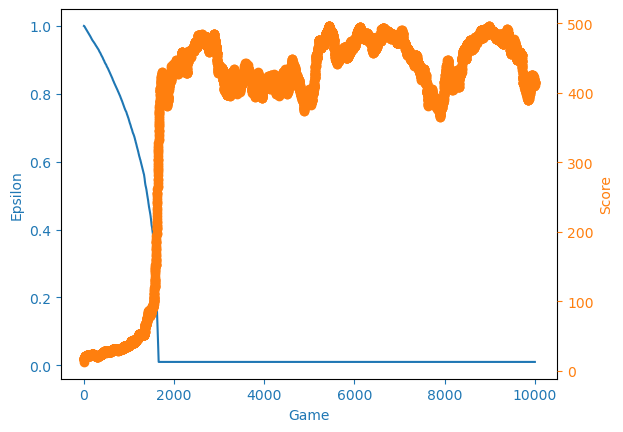

In [6]:
filename = 'cartpole_naive_dqn.png'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)